In [12]:
from matplotlib import pyplot as plt
import numpy as np

from metrics.mot_ground_truth_assigner import MOTGroundTruthAssigner
from models.ocsort_utils.metric_utils import iou_batch


print(plt.rcParams["figure.figsize"])

[6.4, 4.8]


In [13]:
class PrecomputedMOTTracker():

    def __init__(self, seq_path=None):
        self.seq_dets = np.loadtxt(seq_path, delimiter=',')
        
        self.last_frame = int(self.seq_dets[:, 0].max())
    
    def __call__(self, frame):
        tracks = self.seq_dets[self.seq_dets[:, 0] == frame, :]
        return tracks

In [14]:
def center(tracks):
    cx = tracks[..., 0] + (tracks[..., 2] / 2.0)
    cy = tracks[..., 1] + (tracks[..., 3] / 2.0)

    return cx, cy

def speed(tracks1, tracks2):

    cx1, cy1 = center(tracks1)
    cx2, cy2 = center(tracks2)

    dx = cx1 - cx2
    dy = cy1 - cy2

    return dx, dy

def compute_iou(tracks1, tracks2):
    xx1 = np.maximum(tracks1[:, 0], tracks2[:, 0])
    yy1 = np.maximum(tracks1[:, 1], tracks2[:, 1])
    xx2 = np.minimum(tracks1[:, 0] + tracks1[:, 2], tracks2[:, 0] + tracks2[:, 2])
    yy2 = np.minimum(tracks1[:, 1] + tracks1[:, 3], tracks2[:, 1] + tracks2[:, 3])

    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)

    intersection_area_matrix = w * h

    area_test = tracks1[:, 2] * tracks1[:, 3]
    area_gt = tracks2[:, 2] * tracks2[:, 3]

    union_area_matrix = (area_test + area_gt - intersection_area_matrix) # N, M

    iou = intersection_area_matrix / union_area_matrix

    return iou

In [15]:

gt_tracker = PrecomputedMOTTracker('./DATA/output_4_gt.txt')
tracker = PrecomputedMOTTracker('./OUTPUT/ocsort_tracking_output_4.txt')

tracks_assigner = MOTGroundTruthAssigner(iou_batch)


In [16]:
def concat_speed_and_iou(tracker: PrecomputedMOTTracker):
    tck_id_sort = np.argsort(tracker.seq_dets[:, 1])

    first_mask = ~(tracker.seq_dets[tck_id_sort[:-1], 1] == tracker.seq_dets[tck_id_sort[1:], 1])
    discontinuity_mask = ~((tracker.seq_dets[tck_id_sort[:-1], 0] + 1) == tracker.seq_dets[tck_id_sort[1:], 0])

    dx, dy = speed(tracker.seq_dets[tck_id_sort[1:], 2:6], tracker.seq_dets[tck_id_sort[:-1], 2:6])
    iou = compute_iou(tracker.seq_dets[tck_id_sort[1:], 2:6], tracker.seq_dets[tck_id_sort[:-1], 2:6])
    
    # TODO: Discontinuity mask could be used for dividing by the number of frames between detections

    dx[first_mask & discontinuity_mask] = np.nan
    dy[first_mask & discontinuity_mask] = np.nan
    iou[first_mask & discontinuity_mask] = np.nan

    sorted_seqs = np.hstack(
        (tracker.seq_dets[tck_id_sort].reshape(-1, 10),
         np.concatenate(([np.nan], dx)).reshape(-1, 1),
         np.concatenate(([np.nan], dy)).reshape(-1, 1),
         np.concatenate(([np.nan], iou)).reshape(-1, 1))
    )
    tracker.seq_dets = np.empty(sorted_seqs.shape)
    tracker.seq_dets[tck_id_sort] = sorted_seqs

    return tracker

Ground Truth speed
	Mean: 16.82 px/frame
	Variance: 130.57


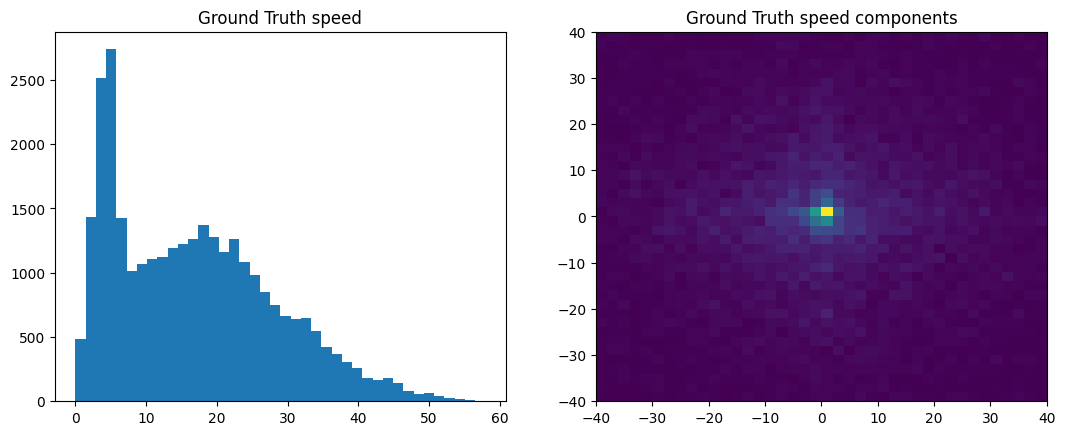

In [17]:
# Speed of gt_tracks, histogram, mean and variance
if gt_tracker.seq_dets.shape[-1] == 10:
    concat_speed_and_iou(gt_tracker)

gt_valid_mask = np.isfinite(gt_tracker.seq_dets[:, 12])
gt_speed_mod = np.sqrt(np.linalg.norm(gt_tracker.seq_dets[gt_valid_mask, 10:12], axis=1))

gt_speed_mean = np.mean(gt_speed_mod)
gt_speed_var = np.var(gt_speed_mod)

plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(gt_speed_mod, bins=40)
plt.title('Ground Truth speed')

plt.subplot(1, 2, 2)
plt.hist2d(gt_tracker.seq_dets[gt_valid_mask, 10], gt_tracker.seq_dets[gt_valid_mask, 11], bins=40, range=[[-40, 40], [-40, 40]])
plt.title('Ground Truth speed components')

print(f'Ground Truth speed\n\tMean: {gt_speed_mean:,.02f} px/frame\n\tVariance: {gt_speed_var:,.02f}')


Tracker speed
	Mean: 17.42 px/frame
	Variance: 130.48


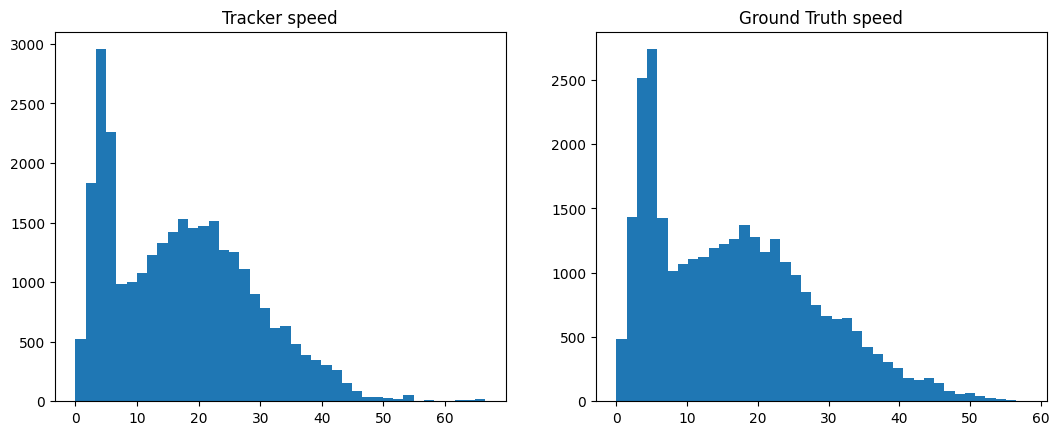

In [18]:
# Speed of tracks, histogram, mean and variance
if tracker.seq_dets.shape[-1] == 10:
    tracker.seq_dets = tracker.seq_dets[tracker.seq_dets[:, 0] <= gt_tracker.seq_dets[:, 0].max(), :]
    concat_speed_and_iou(tracker)

tck_valid_mask = np.isfinite(tracker.seq_dets[:, 12])
tck_speed_mod = np.sqrt(np.linalg.norm(tracker.seq_dets[tck_valid_mask, 10:12], axis=1))

tck_speed_mean = np.mean(tck_speed_mod)
tck_speed_var = np.var(tck_speed_mod)

plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(tck_speed_mod, bins=40)
plt.title('Tracker speed')

plt.subplot(1, 2, 2)
plt.hist(gt_speed_mod, bins=40)
plt.title('Ground Truth speed')

print(f'Tracker speed\n\tMean: {tck_speed_mean:,.02f} px/frame\n\tVariance: {tck_speed_var:,.02f}')

Text(0.5, 1.0, 'Ground Truth IoU t-1 to t without 0s')

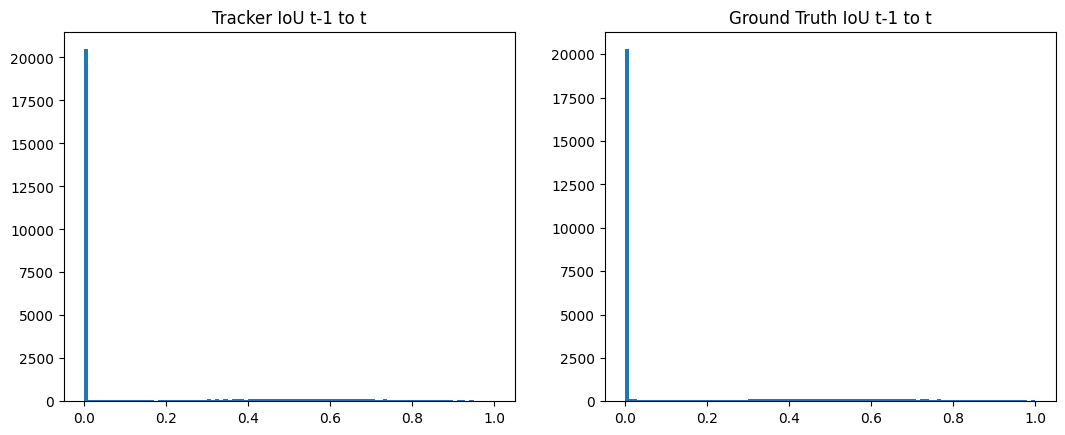

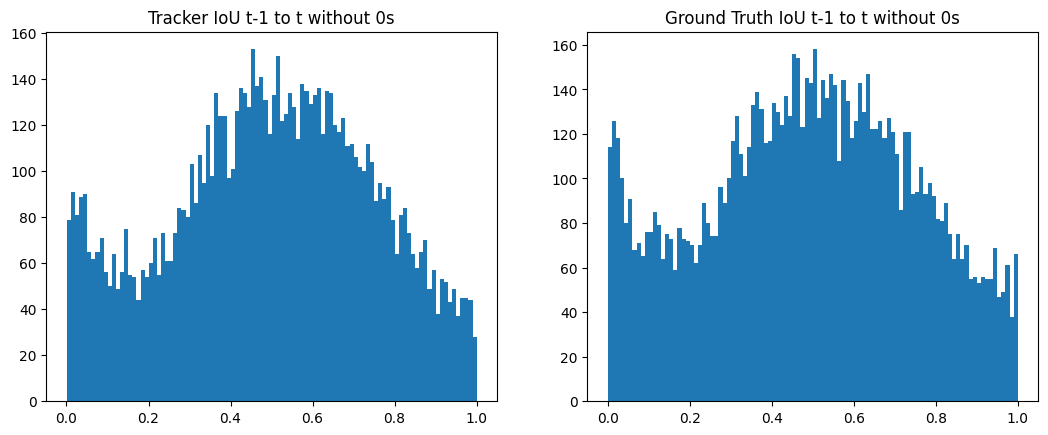

In [19]:
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(tracker.seq_dets[tck_valid_mask, 12], bins=100)
plt.title('Tracker IoU t-1 to t')

plt.subplot(1, 2, 2)
plt.hist(gt_tracker.seq_dets[gt_valid_mask, 12], bins=100)
plt.title('Ground Truth IoU t-1 to t')

plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist([v for v in tracker.seq_dets[tck_valid_mask, 12] if v != 0], bins=100)
plt.title('Tracker IoU t-1 to t without 0s')

plt.subplot(1, 2, 2)
plt.hist([v for v in gt_tracker.seq_dets[gt_valid_mask, 12] if v != 0], bins=100)
plt.title('Ground Truth IoU t-1 to t without 0s')

# TODO: cIoU

In [20]:
print(compute_iou(np.array([[2, 2, 5, 5]]), np.array([[2, 2, 5, 5]])))
print(compute_iou(np.array([[2, 2, 2.5, 5]]), np.array([[2, 2, 5, 5]])))
print(compute_iou(np.array([[2, 2, 2.5, 2.5]]), np.array([[2, 2, 5, 5]])))
print(compute_iou(np.array([[2, 4.5, 2.5, 5]]), np.array([[2, 2, 5, 5]])))
print(compute_iou(np.array([[7, 7, 5, 5]]), np.array([[2, 2, 5, 5]])))

[1.]
[0.5]
[0.25]
[0.2]
[0.]


In [21]:

gt_tck_angle_diff = []
gt_tck_mod_diff = []

previous_assigments = np.empty((0, 2), dtype=int)
lost_gt_tracks = dict() # To keep info about gt that has an ID but now are free

id_sw = 0
frag = 0
tp = 0
fp = 0
fn = 0
motp = 0

for frame in range(1, gt_tracker.last_frame + 1):

    gt_tracks = gt_tracker(frame)
    tracks = tracker(frame)
    prev_tracks = tracker(frame-1)

    assigments = tracks_assigner(gt_tracks, tracks) # IDs gt, IDs tck

    tp += len(assigments)
    fp += len(tracks) - len(assigments)
    fn += len(gt_tracks) - len(assigments)

    # Speed of tracks and gt_tracks
    for gt, tck in assigments:

        motp += compute_iou(gt_tracks[gt_tracks[:, 1] == gt, 2:6], tracks[tracks[:, 1] == tck, 2:6])
        # TODO: histograma iou

        if tck in set(prev_tracks[:, 1]):
            origin_track = np.array(center(prev_tracks[prev_tracks[:, 1] == tck, 2:6]))
            gt_track = np.array(center(gt_tracks[gt_tracks[:, 1] == gt, 2:6]))
            pred_track = np.array(center(tracks[tracks[:, 1] == tck, 2:6]))
            
            o_gt = gt_track - origin_track
            m_o_gt = np.sqrt(np.linalg.norm(o_gt)) + np.finfo(o_gt.dtype).eps
            a_o_gt = np.arccos(np.dot(o_gt.T, np.array([[1, 0]]).T)[0, 0] / m_o_gt) * 180 / np.pi
            o_tck = pred_track - origin_track
            m_o_tck = np.sqrt(np.linalg.norm(o_tck)) + np.finfo(o_tck.dtype).eps
            a_o_tck = np.arccos(np.dot(o_tck.T, np.array([[1, 0]]).T)[0, 0] / m_o_tck) * 180 / np.pi

            gt_tck_angle_diff.append(a_o_tck - a_o_gt)
            gt_tck_mod_diff.append(m_o_tck - m_o_gt)

    # ID switch, Fragmentations, TP, FP, FN
    for gt, tck in previous_assigments:
        if gt in set(assigments[:, 0]):
            if tck != assigments[assigments[:, 0] == gt, 1]:
                id_sw += 1
        else:
            frag += 1
            lost_gt_tracks[gt] = tck
    
    for gt, tck in assigments:
        if gt in set(lost_gt_tracks.keys()):
            if lost_gt_tracks[gt] != tck:
                id_sw += 1
            del lost_gt_tracks[gt]

    previous_assigments = assigments

mota = 1 - (fn + fp + id_sw) / len(gt_tracker.seq_dets)
motp = motp[0] / tp

print(f'{id_sw=}\n{frag=}\n{tp=}\n{fp=}\n{fn=}\n{mota=:.02f}\n{motp=:.02f}')

#TODO: IDF1 i HOTA


/tmp/ipykernel_24171/3088988201.py:38: RuntimeWarning: invalid value encountered in arccos
  a_o_gt = np.arccos(np.dot(o_gt.T, np.array([[1, 0]]).T)[0, 0] / m_o_gt) * 180 / np.pi
/tmp/ipykernel_24171/3088988201.py:41: RuntimeWarning: invalid value encountered in arccos
  a_o_tck = np.arccos(np.dot(o_tck.T, np.array([[1, 0]]).T)[0, 0] / m_o_tck) * 180 / np.pi


id_sw=65
frag=344
tp=29592
fp=5
fn=801
mota=0.97
motp=0.91


Text(0.5, 1.0, 'angle diff (track - ground truth), origin point is previous track position')

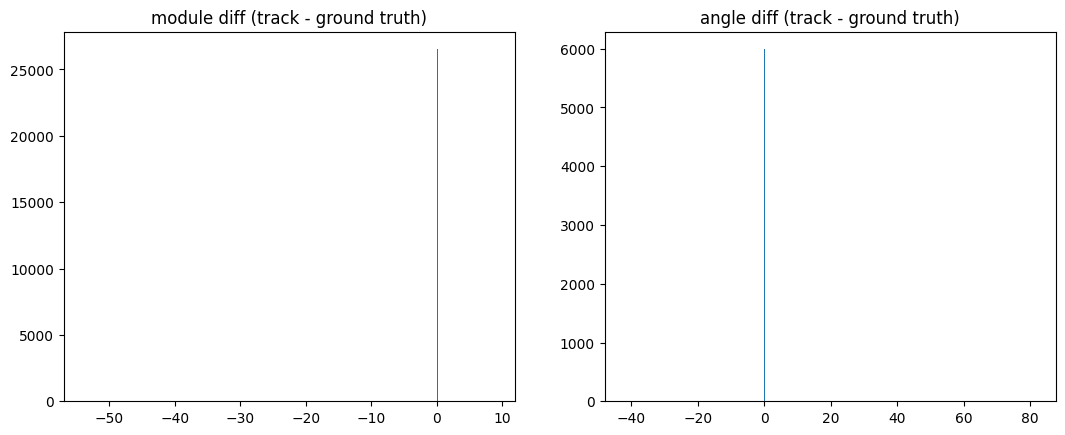

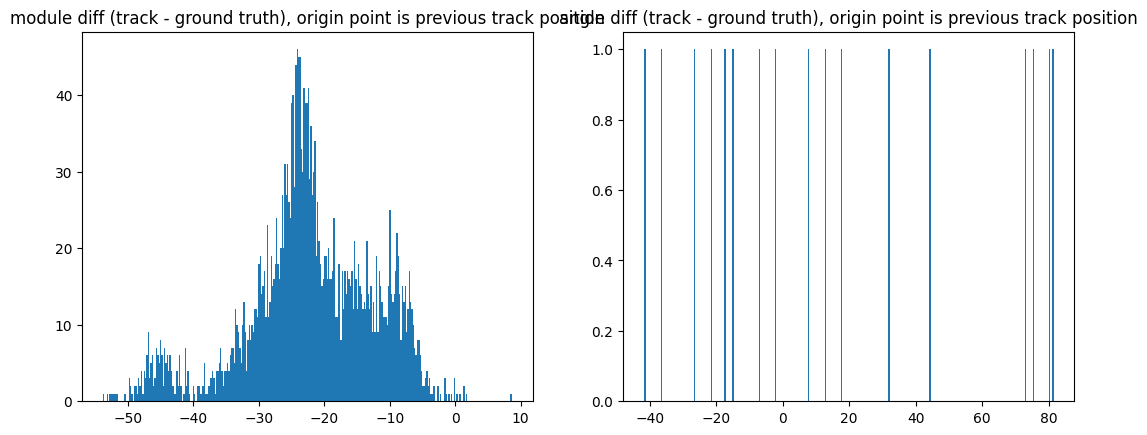

In [22]:
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(gt_tck_mod_diff, bins=300)
plt.title('module diff (track - ground truth)')

plt.subplot(1, 2, 2)
plt.hist(gt_tck_angle_diff, bins=360)
plt.title('angle diff (track - ground truth)')

plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist([v for v in gt_tck_mod_diff if v != 0], bins=300)
plt.title('module diff (track - ground truth), origin point is previous track position')

plt.subplot(1, 2, 2)
plt.hist([v for v in gt_tck_angle_diff if v != 0], bins=360)
plt.title('angle diff (track - ground truth), origin point is previous track position')

# TODO: El que prediu kalman (no deteccio que tenim als resultats)
